In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Fri Oct 24 15:56:24 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = [
            'united_states_of_america',
            #  'brazil',
            #  'china',
            #  'germany',
            #  'israel',
            #  'japan',
            #  'spain',
            #  'sweden',
            #  'taiwan_(province_of_china)',
            #  'united_kingdom',
            ]



results_dirs = [
    'results/model7.2/model_spec/2025_10_22_11_41_57/results/',
    # 'results/model5.0/model_spec/2025_09_25_09_02_38/results/',
]

artifact_dirs = ['artifacts/model7.0/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model7.0/united_states_of_america.hdf']

In [4]:
apath = artifact_dirs[0]
!ls $apath

artifacts/model7.0/united_states_of_america.hdf


In [5]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [6]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [7]:
filters = [('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[0])]
test = pd.read_parquet(results_dirs[0] + 'deaths' + '.parquet', filters=filters)
test['location'] = locations[0]
test.artifact_path.unique()

array(['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'],
      dtype=object)

In [67]:
def print_memory_usage(df, label=''):
    """Print the memory usage of a dataframe in megabytes."""
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB', label)

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

def load_df(measure):
    # data = pd.DataFrame()
    dfs_by_location = []
    data_all = pd.read_parquet(
        results_dirs[0] + measure + '.parquet',
        filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[0])],
    )
    print_memory_usage(data_all, 'for parquet file loaded into memory')
    convert_to_categorical(data_all, inplace=True)
    print_memory_usage(data_all, 'after converting to categorical')
    # Loop through unique locations (artifact paths), and aggregate
    # random seeds for each one, then concatenate
    for artifact in data_all.artifact_path.unique():
        temp = data_all[data_all.artifact_path == artifact]

        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols, observed=True)['value'].sum().reset_index()
        
        temp['location'] = locations[0]
        # temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['event_year'] = temp['event_year'].astype(int)
        # data = pd.concat([data, temp], ignore_index=True)
        dfs_by_location.append(temp)
    data = pd.concat(dfs_by_location, ignore_index=True)
    print_memory_usage(data, 'after aggregating seeds')
    convert_to_categorical(data, exclude_cols=['event_year'], inplace=True)
    print_memory_usage(data, 'after converting aggregated data to categoricals')
    return data

In [68]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time
# person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

7756.570009 MB for parquet file loaded into memory
323.202814 MB after converting to categorical
332.429862 MB after aggregating seeds
86.190051 MB after converting aggregated data to categoricals


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,346,baseline,346,0.000000,united_states_of_america
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,346,bbbm_testing_and_treatment,346,0.000000,united_states_of_america
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,2,0.000000,united_states_of_america
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,2,bbbm_testing_and_treatment,2,0.000000,united_states_of_america
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,177,baseline,177,0.000000,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,199,bbbm_testing_and_treatment,199,224.229979,united_states_of_america
3077996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,323,baseline,323,0.000000,united_states_of_america
3077997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,323,bbbm_testing_and_treatment,323,232.700890,united_states_of_america
3077998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,158,baseline,158,0.000000,united_states_of_america


In [71]:
person_time.memory_usage(deep=True)

Index                     132
measure               3078176
entity_type           3078170
entity                3078203
sub_entity            3078383
age_group             3079530
event_year           24624000
sex                   3078232
treatment             3078992
artifact_path         3078276
input_draw_number     3078756
scenario              3078256
input_draw            3078756
value                24624000
location              3078189
dtype: int64

In [72]:
person_time.dtypes

measure              category
entity_type          category
entity               category
sub_entity           category
age_group            category
event_year              int64
sex                  category
treatment            category
artifact_path        category
input_draw_number    category
scenario             category
input_draw           category
value                 float64
location             category
dtype: object

In [73]:
# This is insane -- 45 GB!
print_memory_usage(person_time)

86.190051 MB 


In [74]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [75]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        1.926180e+08
alzheimers_disease_state                      3.355238e+08
alzheimers_mild_cognitive_impairment_state    1.632724e+08
Name: value, dtype: float64

In [76]:
person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                     alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
united_states_of_america 2025       25_to_29                                 5.979466   
                                    30_to_34                              3426.234086   
                                    35_to_39                              3751.118412   
                                    40_to_44                              3592.662560   
                                    45_to_49                             10837.782341   
...                                                                               ...   
                         2100       75_to_79                            504475.099247   
                                    80_to_84                            580615.129363   
                                    85_to_89                            506244.024641   
                                    90_to_94                            233375.074606   
                                    95_plus                              37193.774127   

sub_entity                                     alzheimers_disease_state  \
location                 event_year age_group                             
united_states_of_america 2025       25_to_29               0.000000e+00   
                                    30_to_34               1.375277e+02   
                                    35_to_39               1.604490e+02   
                                    40_to_44               1.195893e+02   
                                    45_to_49               4.365010e+02   
...                                                                 ...   
                         2100       75_to_79               7.622215e+05   
                                    80_to_84               1.085579e+06   
                                    85_to_89               1.153316e+06   
                                    90_to_94               7.618831e+05   
                                    95_plus                2.805247e+05   

sub_entity                                     alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
united_states_of_america 2025       25_to_29                                     2.989733  
                                    30_to_34                                  2118.724162  
                                    35_to_39                                  2303.091034  
                                    40_to_44                                  2256.251882  
                                    45_to_49                                  6769.752225  
...                                                                                   ...  
                         2100       75_to_79                                404684.785763  
                                    80_to_84                                489343.561944  
                                    85_to_89                                450463.578371  
                                    90_to_94                                239175.156742  
                                    95_plus                                  58650.590007  

[1140 rows x 3 columns]

In [77]:
#assert np.all(person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [78]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

5222.350002 MB for parquet file loaded into memory
215.472812 MB after converting to categorical
221.62186 MB after aggregating seeds
57.462049 MB after converting aggregated data to categoricals


0.0

In [79]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [80]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [81]:
out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
#out_counts

In [82]:
out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
#out_rates['alzheimers_blood_based_biomarker_state'].unstack()

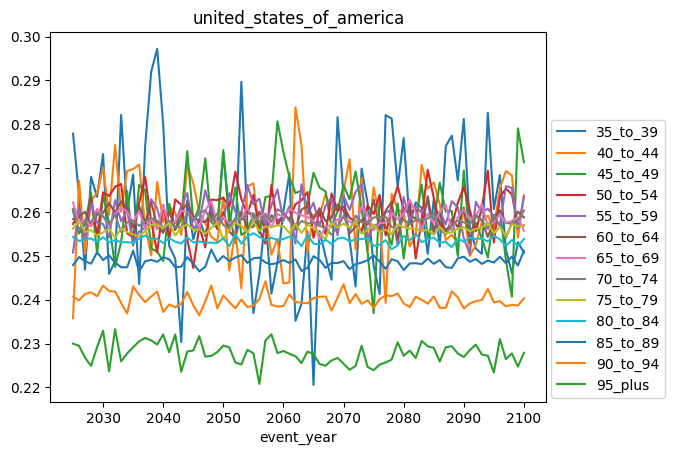

In [83]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,2:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

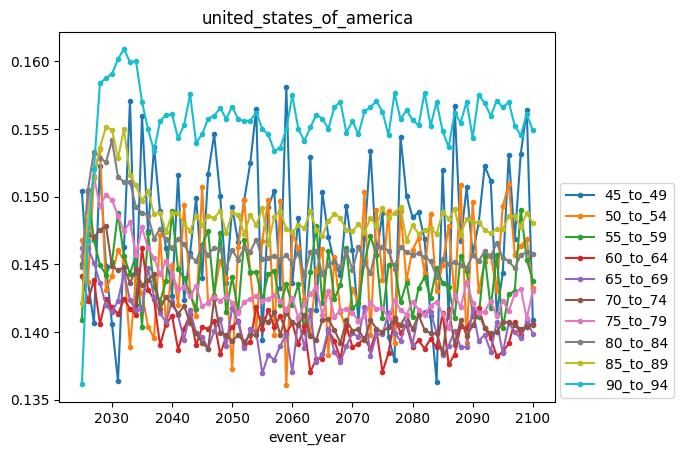

In [84]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,4:14].plot(marker='.')
    plt.title(location)
    plt.legend(loc=(1.01, .01))

In [85]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
#mci_duration_est

In [86]:
new_sims = load_df('counts_new_simulants').groupby(['location', 'event_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
#bbbm_duration_est

157.898634 MB for parquet file loaded into memory
9.13089 MB after converting to categorical
11.745938 MB after aggregating seeds
2.626127 MB after converting aggregated data to categoricals


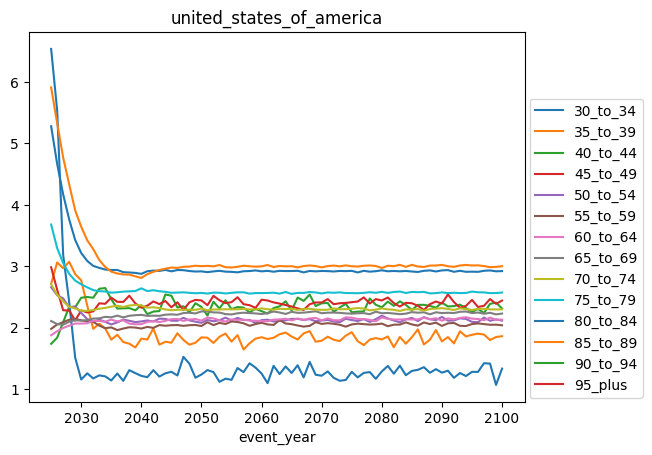

In [87]:
t = bbbm_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

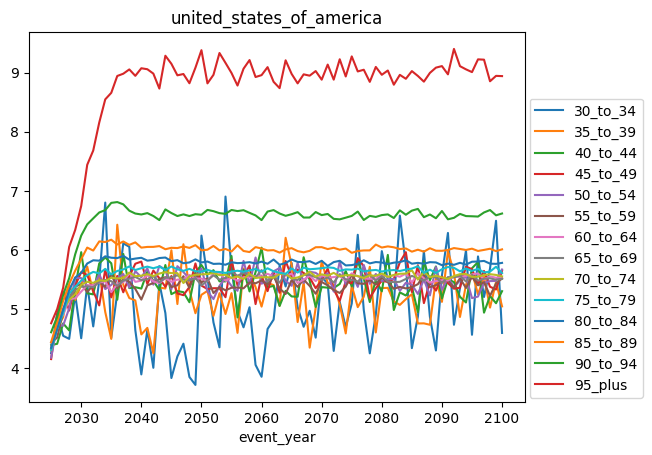

In [88]:
t = mci_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [89]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

def calculate_ocmr():
    # FIXME: We already loaded person-time, so we don't need to load again
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

7756.570009 MB for parquet file loaded into memory
323.202814 MB after converting to categorical
332.429862 MB after aggregating seeds
86.190051 MB after converting aggregated data to categoricals
391.02932 MB for parquet file loaded into memory
22.811747 MB after converting to categorical
24.400795 MB after aggregating seeds
6.160984 MB after converting aggregated data to categoricals
CPU times: user 41.6 s, sys: 7.03 s, total: 48.6 s
Wall time: 36.1 s


In [90]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)]
    art_ocmr = pd.concat([art_ocmr, data4])
#art_ocmr

In [91]:
art_data = art_ocmr
# location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [92]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.event_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


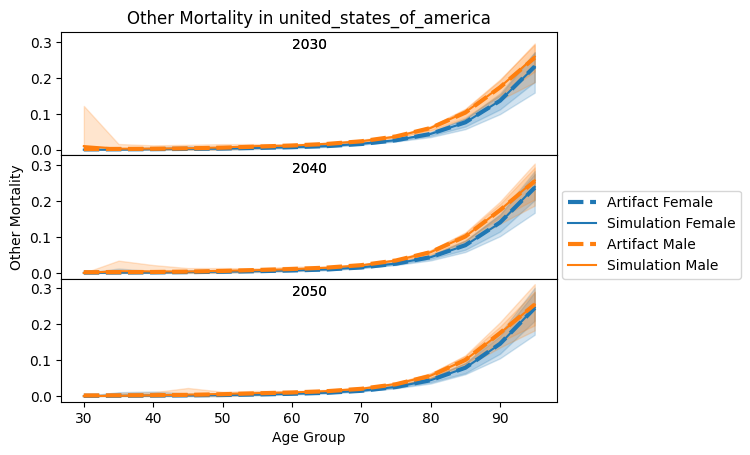

In [93]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [94]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.event_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

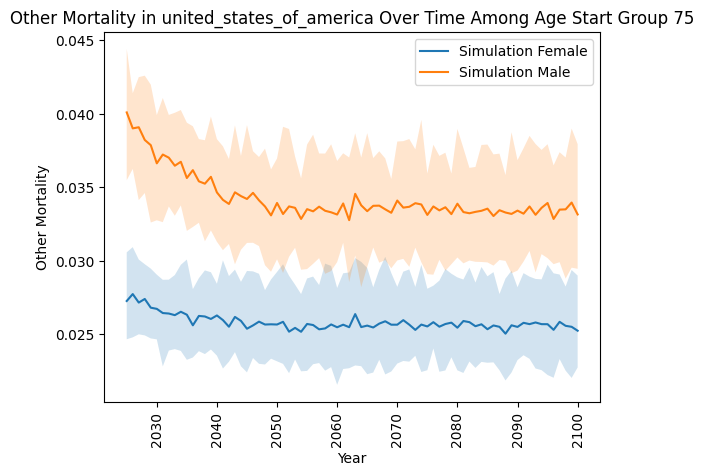

<Figure size 640x480 with 0 Axes>

In [95]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [96]:
cols = ['input_draw','event_year','location','age_group','sex']

def calculate_emr():
    # FIXME: Don't reload person-time
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

7756.570009 MB for parquet file loaded into memory
323.202814 MB after converting to categorical
332.429862 MB after aggregating seeds
86.190051 MB after converting aggregated data to categoricals
391.02932 MB for parquet file loaded into memory
22.811747 MB after converting to categorical
24.400795 MB after aggregating seeds
6.160984 MB after converting aggregated data to categoricals


In [97]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)]
        out = pd.concat([out, data])
    return out

In [98]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

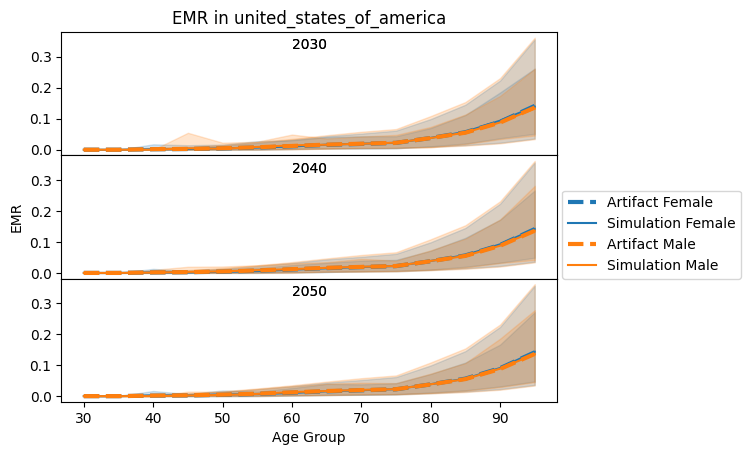

In [99]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

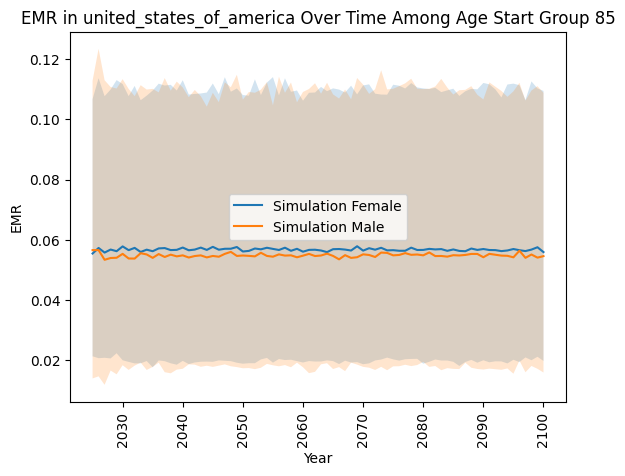

<Figure size 640x480 with 0 Axes>

In [100]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [101]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    # df['location'] = df.location.str.replace(' ', '_').str.lower()
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
art_incidence_data.tail()
    

draw_0  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      10546.549825   
                                                2047       2048      10813.380822   
                                                2048       2049      11090.191756   
                                                2049       2050      11365.186769   
                                                2050       2051      11620.493269   

                                                                           draw_1  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      10216.948418   
                                                2047       2048      10512.051381   
                                                2048       2049      10827.213359   
                                                2049       2050      11138.174690   
                                                2050       2051      11417.515932   

                                                                          draw_2  \
sex  age_start age_end location                 year_start year_end                
Male 95.0      125.0   United States of America 2046       2047      7910.522723   
                                                2047       2048      8130.611817   
                                                2048       2049      8358.854424   
                                                2049       2050      8583.196759   
                                                2050       2051      8793.232171   

                                                                           draw_3  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      12084.221967   
                                                2047       2048      12489.675061   
                                                2048       2049      12919.955031   
                                                2049       2050      13344.844961   
                                                2050       2051      13744.105189   

                                                                          draw_4  \
sex  age_start age_end location                 year_start year_end                
Male 95.0      125.0   United States of America 2046       2047      7349.129966   
                                                2047       2048      7490.310322   
                                                2048       2049      7633.597729   
                                                2049       2050      7768.884684   
                                                2050       2051      7881.931278   

                                                                           draw_5  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      10743.548534   
                                                2047       2048      11113.982782   
                                                2048       2049      11489.685650   
                                                2049       2050      11862.807336   
                                                2050       2051      12229.766694   

                                                                          draw_6  \
sex  age_start age_end location                 year_start year_end                
Male 95.0      125.0   United States of America 2046       2047      8095.587555   
                                                2047       2048      8364.685614   
                                                2048       2049      8646.514898   
                                                2049       2050      8918.936539   
         

In [102]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2023"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    ratio = 100_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'event_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.018283685923580616


In [103]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
united_states_of_america,168.0,0.003657,6.943028e-19,0.003657,0.003657,0.003657,0.003657,0.003657


In [104]:
cols = ['input_draw','event_year','location','age_group','sex']

new_sims = load_df('counts_new_simulants')
new_sims.head()

157.898634 MB for parquet file loaded into memory
9.13089 MB after converting to categorical
11.745938 MB after aggregating seeds
2.626127 MB after converting aggregated data to categoricals


,age_group,event_year,sex,artifact_path,input_draw_number,scenario,input_draw,value,location
0,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,346,baseline,346,0.0,united_states_of_america
1,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,346,bbbm_testing_and_treatment,346,0.0,united_states_of_america
2,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,2,0.0,united_states_of_america
3,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,bbbm_testing_and_treatment,2,0.0,united_states_of_america
4,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,177,baseline,177,0.0,united_states_of_america


In [ ]:
# FIXME: Don't reload transitions
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

5222.350002 MB for parquet file loaded into memory
215.472812 MB after converting to categorical
221.62186 MB after aggregating seeds
57.462049 MB after converting aggregated data to categoricals


In [106]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])

In [107]:
#new_ad_dementia

In [108]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [109]:
new_ad_dementia_summary = summarize(new_ad_dementia)
#new_ad_dementia_summary

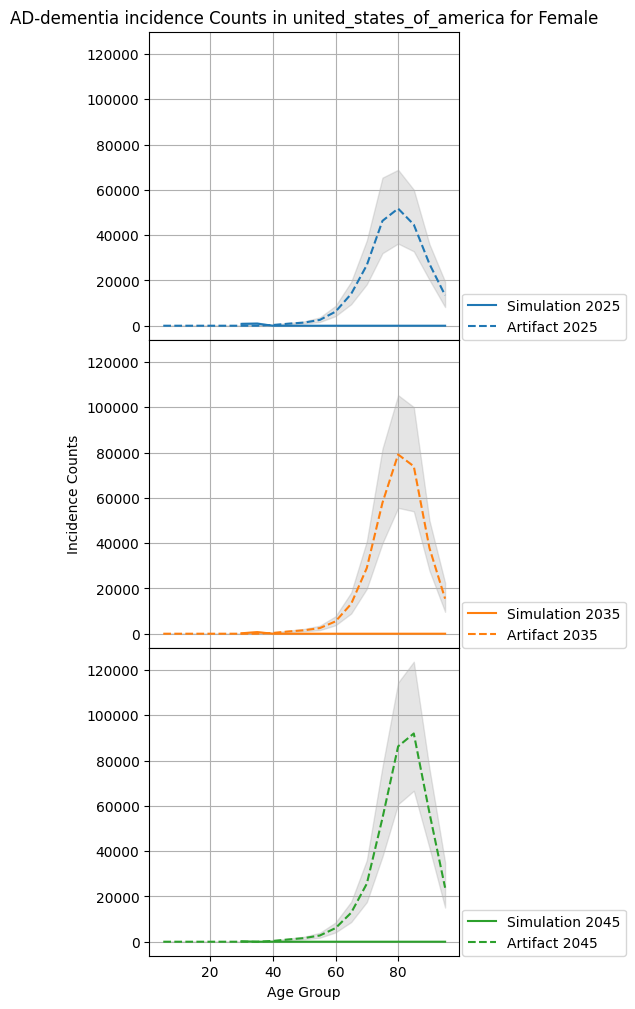

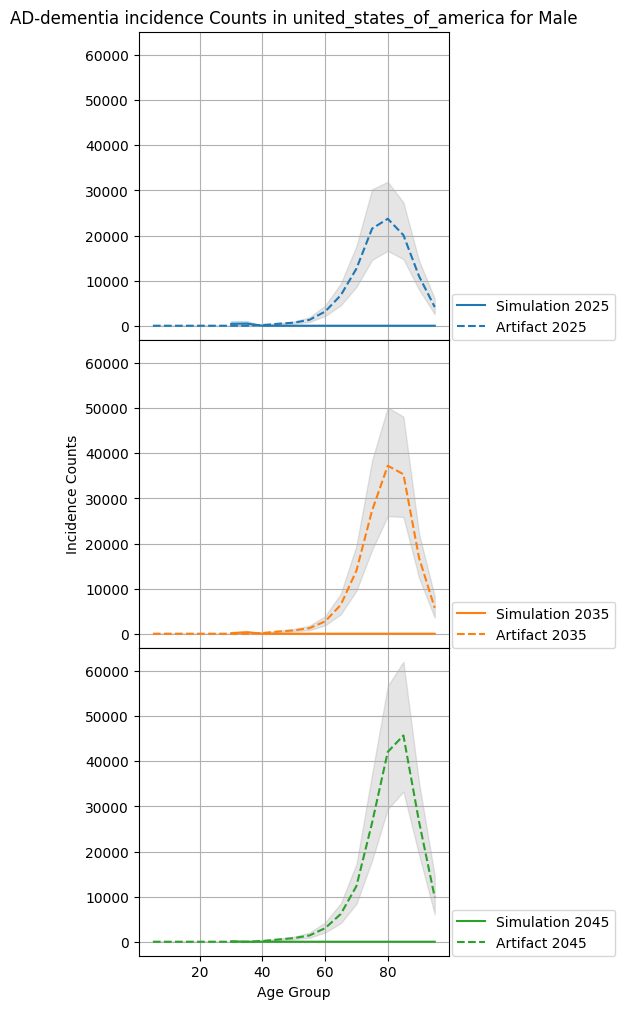

In [110]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and event_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))


I did some manual checks against GBD compare to make sure these were less than those, with the expectation they are about half. 

In [111]:
plot_data

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
41,2045,united_states_of_america,30_to_34,Male,25.0,78.758736,92.171237,0.0,0.0,109.387134,262.529121,328.161402,11,30 to 34,30.0,35.0
93,2045,united_states_of_america,35_to_39,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,12,35 to 39,35.0,40.0
145,2045,united_states_of_america,40_to_44,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,13,40 to 44,40.0,45.0
197,2045,united_states_of_america,45_to_49,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,14,45 to 49,45.0,50.0
249,2045,united_states_of_america,50_to_54,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,15,50 to 54,50.0,55.0
301,2045,united_states_of_america,55_to_59,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,16,55 to 59,55.0,60.0
353,2045,united_states_of_america,60_to_64,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,17,60 to 64,60.0,65.0
405,2045,united_states_of_america,65_to_69,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,18,65 to 69,65.0,70.0
457,2045,united_states_of_america,70_to_74,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,19,70 to 74,70.0,75.0
509,2045,united_states_of_america,75_to_79,Male,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,20,75 to 79,75.0,80.0


## Verifying Prevalence

In [112]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_1  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_2  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_3  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_4  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_5  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_6  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_7  \
sex    age_sta

In [113]:
# FIXME: Wrong name, and don't reload
new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims.sub_entity.unique()

7756.570009 MB for parquet file loaded into memory
323.202814 MB after converting to categorical
332.429862 MB after aggregating seeds
86.190051 MB after converting aggregated data to categoricals


['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [114]:
cols = ['input_draw','event_year','location','age_group','sex']

# FIXME: Wrong name, and don't reload
new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.loc[new_sims.sub_entity == 'alzheimers_disease_state']
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

7756.570009 MB for parquet file loaded into memory
323.202814 MB after converting to categorical
332.429862 MB after aggregating seeds
86.190051 MB after converting aggregated data to categoricals


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
723,2048,united_states_of_america,95_plus,Male,25.0,151715.261756,53131.200840,72711.522139,79399.455997,152290.849217,238509.054404,260486.030211,33,95 to 99,95.0,125.0
724,2049,united_states_of_america,95_plus,Female,25.0,385440.835513,132345.840033,168724.525323,184569.532434,404110.363671,577893.081839,591612.339802,33,95 to 99,95.0,125.0
725,2049,united_states_of_america,95_plus,Male,25.0,156582.682241,55013.542303,75845.639472,81830.440920,155397.713357,249132.349505,272041.384554,33,95 to 99,95.0,125.0
726,2050,united_states_of_america,95_plus,Female,25.0,393754.149873,135805.002294,172976.023619,183097.859947,413185.677342,586248.911182,606737.862585,33,95 to 99,95.0,125.0
727,2050,united_states_of_america,95_plus,Male,25.0,161697.561729,57288.726030,78162.160980,84523.056507,162565.303433,260115.386770,282533.864323,33,95 to 99,95.0,125.0


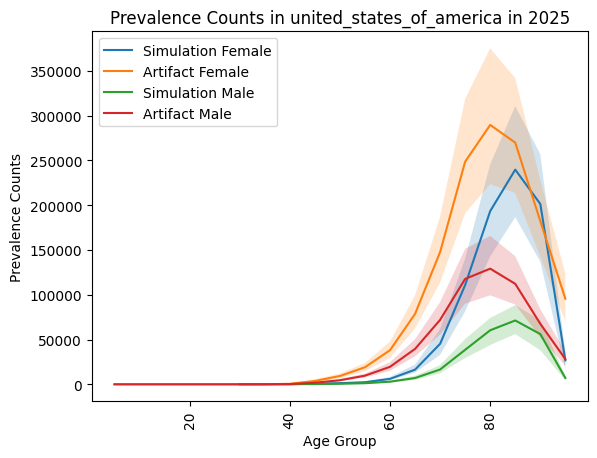

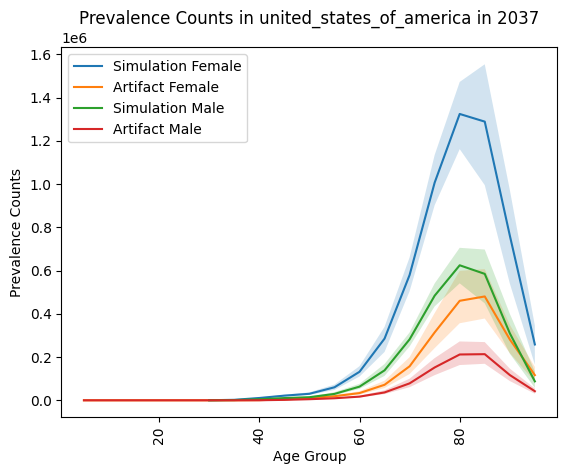

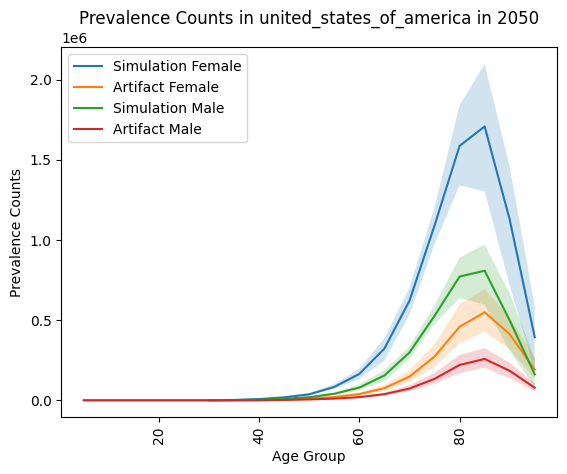

<Figure size 640x480 with 0 Axes>

In [115]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique(): # [:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.event_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [ ]:
cols = ['input_draw','event_year','location'] #, 'age_group']

# FIXME: Don't reload person-time
person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

7756.570009 MB for parquet file loaded into memory
323.202814 MB after converting to categorical
332.429862 MB after aggregating seeds
86.190051 MB after converting aggregated data to categoricals


,event_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,united_states_of_america,25.0,202969.868090,282.294200,202415.890486,202499.603012,202933.114305,203403.897604,203407.485284
1,2026,united_states_of_america,25.0,216886.517399,1247.306779,214411.696099,214768.072279,216793.516769,218809.792745,219083.652293
2,2027,united_states_of_america,25.0,230061.314278,2384.547257,225716.873374,225853.205202,229974.253251,233789.750582,234147.920602
3,2028,united_states_of_america,25.0,242533.683340,3652.827645,235980.626968,235984.214648,242540.101300,248205.645448,248226.573580
4,2029,united_states_of_america,25.0,254505.411636,5099.320202,245518.872005,245578.666667,255084.024641,262089.367830,262143.780972


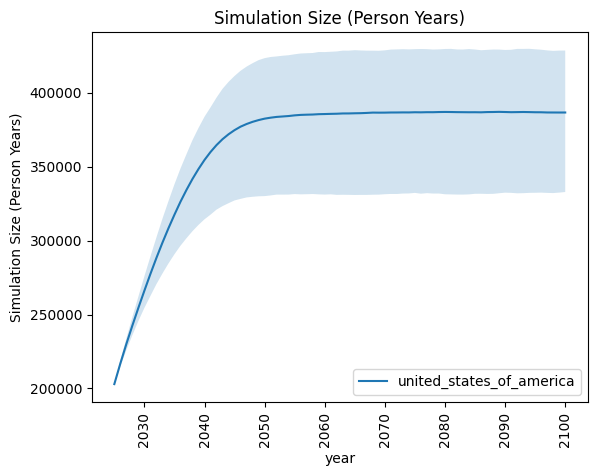

In [117]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.event_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()

86.190051 MB 
